# Cooling Loops in a Stellar Corona

In [1]:
#import pdb
import datetime
import os
import subprocess
import multiprocessing

from scipy.io import readsav
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import sunpy.sun.constants
from sunpy.map import Map,GenericMap
import astropy.units as u
import yt
from astropy.coordinates import SkyCoord
import sunpy.cm

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,UniformHeating

from sav_converter import sav_to_hpc_map

%matplotlib inline

## Construct SunPy Map from IDL Data

In [3]:
hemispheremap0 = sav_to_hpc_map('/Users/willbarnes/Downloads/0long166800.sav',pad=10)
hemispheremap180 = sav_to_hpc_map('/Users/willbarnes/Downloads/180long166800.sav',pad=10)

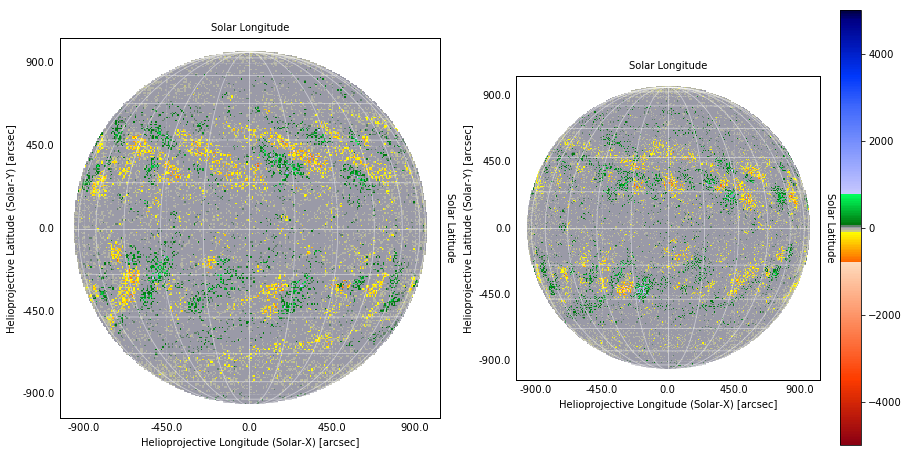

In [4]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(121,projection=hemispheremap0)
hemispheremap0.plot(axes=ax,title=False)
hemispheremap0.draw_grid(axes=ax)
ax = fig.add_subplot(122,projection=hemispheremap180)
im = hemispheremap180.plot(axes=ax,title=False)
hemispheremap180.draw_grid(axes=ax)
fig.colorbar(im)

## Create SynthesizAR Field Object

Now that we have our data in terms of SunPy maps, we are ready to pass it to synthesizAR.

In [5]:
field = synthesizAR.Skeleton(hmi_fits_file=hemispheremap0,
                             resample=u.Quantity([125,125],u.pixel)
                            )

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [6]:
field.extrapolate_field(zshape=100, zrange=u.Quantity([0,2000],u.arcsec))

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:81: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-ro

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/field.py:187: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/field.py:188: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/field.py:195: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/Users/willbarnes/anaconda/envs/synthesizar/lib/p

In [7]:
field.extract_streamlines(1000,mask_threshold=0.01,safety=5,loop_length_range=[5e9,1e11]*u.cm,close_threshold=0.025)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/util/util.py:64: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.6/site-packages/synthesizAR-0.1.dev543-py3.6.egg/synthesizAR/util/util.py:65: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2018-01-09 15:36:30,323 AMRKDTree rebuilt, Final Volume: 2.941929e+33
Streamlining: 100%|██████████| 1000/1000 [00:00<00:00, 1072.81it/s]
yt : [INFO     ] 2018-01-09 15:36:32,475 AMRKDTree rebuilt, Final Volume: 2.941929e+33
Streamlining: 100%|██████████| 463/463 [00:00<00:00, 1097.78it/s]
yt : [INFO     ] 2018-01-09 15:36:33,700 AMRKDTree rebuilt, Final Volume: 2.941929e+33
Streaml

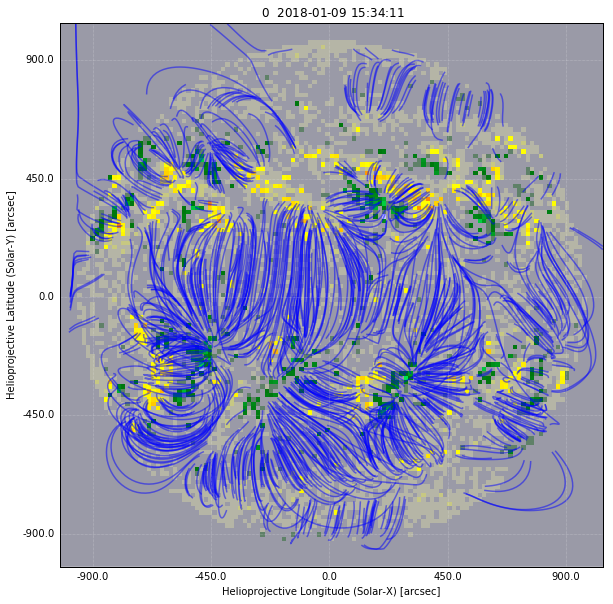

In [8]:
field.peek(alpha=0.5)

In [9]:
field.make_loops()

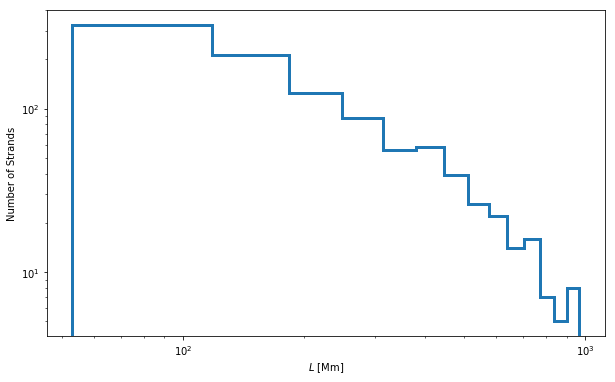

In [10]:
plt.figure(figsize=(10,6))
plt.hist([loop.full_length.to(u.Mm).value for loop in field.loops],histtype='step',lw=3,bins='scott');
plt.xlabel(r'$L$ [Mm]')
plt.ylabel(r'Number of Strands')
plt.xscale('log')
plt.yscale('log')

yt : [INFO     ] 2018-01-09 15:37:17,053 Projection completed
yt : [INFO     ] 2018-01-09 15:37:17,055 xlim = -71109566720.267517 74579592431.196075
yt : [INFO     ] 2018-01-09 15:37:17,056 ylim = -71109566730.467682 74579592420.995911
yt : [INFO     ] 2018-01-09 15:37:17,059 xlim = -71109566720.267517 74579592431.196075
yt : [INFO     ] 2018-01-09 15:37:17,060 ylim = -71109566730.467682 74579592420.995911
yt : [INFO     ] 2018-01-09 15:37:17,062 Making a fixed resolution buffer of (('stream', 'Bz')) 800 by 800
yt : [WARNING  ] 2018-01-09 15:37:17,089 Plot image for field ('stream', 'Bz') has both positive and negative values. Min = -1070339223.436661, Max = 1105819663.658072.
yt : [WARNING  ] 2018-01-09 15:37:17,090 Switching to symlog colorbar scaling unless linear scaling is specified later
yt : [INFO     ] 2018-01-09 15:37:17,548 Projection completed
yt : [INFO     ] 2018-01-09 15:37:17,680 Projection completed



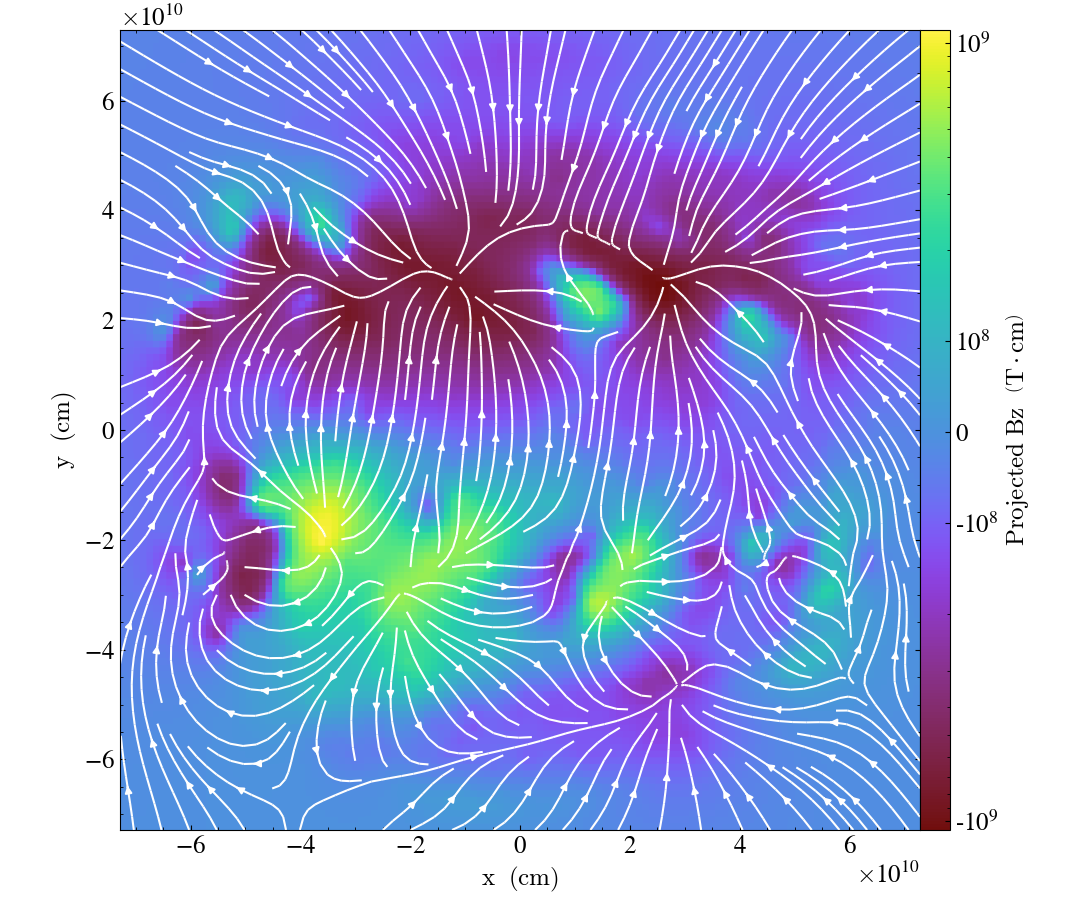

In [11]:
center=(field.extrapolated_3d_field.domain_center
        +np.array([0,0,-0.4])*field.extrapolated_3d_field.domain_width)
p = yt.ProjectionPlot(field.extrapolated_3d_field,'z','Bz',
                 #origin='lower-right-domain',
                 axes_unit='cm',
                 #center=center,
                 #width=((1*extrap_field.domain_width.value[1],'cm'),
                 #       (1*extrap_field.domain_width.value[2],'cm'))
                )
p.annotate_streamlines('Bx','By',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-1e3,1e3)
#p.set_log('Bz',True,linthresh=5e-2)
p.show()

## Heating Model
To start off with, we'll just use a simple cooling model that will last around 5000 s

In [ ]:
heating_options = {
    'duration':200,
    'average_waiting_time':4800,
    'duration_rise':100,
    'duration_decay':100,
    'stress_level':0.3
}
heating_model = UniformHeating(heating_options)

## Sandbox

In [ ]:
lcx, rcx = hemispheremap0.xrange + hemispheremap0.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
lcy, rcy = hemispheremap0.yrange + hemispheremap0.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
bottom_left = SkyCoord(lcx, lcy, frame=hemispheremap0.coordinate_frame)
top_right = SkyCoord(rcx, rcy, frame=hemispheremap0.coordinate_frame)

In [ ]:
foo = hemispheremap0.submap(bottom_left,top_right)

In [ ]:
foo.peek()

In [ ]:
# Make four corners
bottom_left = u.Quantity(hemispheremap0._get_lon_lat(bottom_left))
top_right = u.Quantity(hemispheremap0._get_lon_lat(top_right))
top_left = u.Quantity([bottom_left[0], top_right[1]])
bottom_right = u.Quantity([top_right[0], bottom_left[1]])

In [ ]:
corners = u.Quantity([bottom_left, bottom_right, top_left, top_right])
coord = SkyCoord(corners,frame=hemispheremap0.coordinate_frame)

In [ ]:
pixel_corners = hemispheremap0.world_to_pixel(coord)

In [ ]:
pixel_corners

In [ ]:
native_frame = coord.transform_to(hemispheremap0.coordinate_frame)

In [ ]:
native_frame

In [ ]:
hemispheremap0.coordinate_frame

In [ ]:
hmi_test = Map('/Users/willbarnes/sunpy/data/hmi_m_45s_2017_08_20_18_16_30_tai_magnetogram.fits')
#hmi_test = hmi_test.rotate()

In [ ]:
hmi_test.meta['date-obs']

In [ ]:
boundary_map = hemispheremap0
mask_threshold = 0.05
safety = 10
number_fieldlines = 500

In [ ]:
mask_above = mask_threshold*np.nanmin(boundary_map.data)
masked_boundary_map = np.ma.masked_invalid(np.ma.masked_greater(boundary_map.data, mask_above))
epsilon_area = float(masked_boundary_map.count())/float(boundary_map.data.shape[0]*boundary_map.data.shape[1])
resample_resolution = int(safety*np.sqrt(number_fieldlines/epsilon_area))

In [ ]:
boundary_map_resampled = boundary_map.resample([resample_resolution, resample_resolution]
                                                *(u.Unit(boundary_map.meta['cunit1'])/boundary_map.scale.axis1.unit),
                                                   method='nearest')
masked_boundary_map_resampled = np.ma.masked_invalid(np.ma.masked_greater(boundary_map_resampled.data, mask_above))
# find the unmasked indices
unmasked_indices = [(ix, iy) for iy, ix in zip(*np.where(masked_boundary_map_resampled.mask == 0))]

In [ ]:
plt.imshow(masked_boundary_map.mask)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(masked_boundary_map,vmin=-5000,vmax=5000,cmap=sunpy.cm.get_cmap('hmimag'))
plt.colorbar()

In [ ]:
boundary_map_resampled.peek()

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(masked_boundary_map_resampled,vmin=-5000,vmax=5000,cmap=sunpy.cm.get_cmap('hmimag'))
plt.colorbar()

In [ ]:
plt.imshow(masked_boundary_map_resampled.mask)
plt.colorbar()

In [ ]:
masked_boundary_map_resampled.mask